# Leitura do DataSet COCO TEXT

Seguindo e modificando roteiro fast.ai


## Carregando arquivos

In [1]:
#instalações
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip3 install http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision cython
!pip3 install pycocotools
!pip install --no-cache-dir -I pillow
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
!wget -q https://raw.githubusercontent.com/robertoalotufo/ia368z/master/PyTorch/lib/pytorch_trainer_v2.py -Plib/

import torch
print(torch.__version__)
print('GPU:', torch.cuda.is_available())
from lib import pytorch_trainer_v2 as ptt
from torch.cuda import get_device_name
print("GPU:" + str(get_device_name(0)))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#imagens
!wget -nc http://images.cocodataset.org/zips/train2014.zip
#anotações
!wget -nc https://s3.amazonaws.com/cocotext/COCO_Text.zip

    100% |████████████████████████████████| 483.0MB 77.7MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x560e4000 @  0x7f0d265d51c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 4.9MB/s 
    100% |████████████████████████████████| 3.4MB 927kB/s 
    100% |████████████████████████████████| 2.0MB 5.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 1.5MB 13.7MB/s 
  Running setup.py bdist_wheel for pycocotools ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/dc/e6/36/0e1ae88c868eb42d3f92181b1c9bbd0b217a7ec3da6bd62e55
Successfully built pycocotools
    100% |██████████████████████

In [0]:
!unzip -q COCO_Text.zip
!unzip -q train2014.zip

## Importanto bibliotecas

In [0]:
from pathlib import Path
import json
import numpy as np
import collections
import matplotlib.pyplot as plt
import cv2
import os


## Analisando arquivo JSON


In [4]:
PATH_I = Path('train2014')
train_j = json.load(open('COCO_Text.json'))
train_j.keys()

dict_keys(['imgs', 'imgToAnns', 'cats', 'anns', 'info'])

In [5]:
list(PATH_I.iterdir())[:5]

[PosixPath('train2014/COCO_train2014_000000024849.jpg'),
 PosixPath('train2014/COCO_train2014_000000364374.jpg'),
 PosixPath('train2014/COCO_train2014_000000317537.jpg'),
 PosixPath('train2014/COCO_train2014_000000360367.jpg'),
 PosixPath('train2014/COCO_train2014_000000222990.jpg')]

In [0]:
IMAGES,ANNOTATIONS,CATEGORIES = ['imgs', 'anns', 'cats']

In [7]:
train_j[CATEGORIES]

{'class': {'1': {'id': 1, 'name': 'machine printed'},
  '2': {'id': 2, 'name': 'handwritten'},
  '3': {'id': 3, 'name': 'others'}},
 'legibility': {'1': {'id': 1, 'name': 'legible'},
  '2': {'id': 2, 'name': 'illegible'}},
 'script': {'1': {'id': 1, 'name': 'english'},
  '2': {'id': 2, 'name': 'not english'},
  '3': {'id': 3, 'name': 'na'}}}

In [8]:
train_j[ANNOTATIONS]['1231468']

{'area': 997.0453941354001,
 'bbox': [380.57979575247066,
  581.7662670169573,
  34.61944800040967,
  28.800152854072127],
 'class': 'machine printed',
 'id': 1231468,
 'image_id': 10581,
 'language': 'english',
 'legibility': 'legible',
 'polygon': [380.57979575247066,
  581.7662670169573,
  415.1992437528803,
  581.7662670169573,
  415.1992437528803,
  610.5664198710294,
  380.57979575247066,
  610.5664198710294],
 'utf8_string': 'BUSM'}

In [9]:
train_j[IMAGES]['534763']

{'file_name': 'COCO_train2014_000000534763.jpg',
 'height': 427,
 'id': 534763,
 'set': 'train',
 'width': 640}

In [0]:
ID, FILE_NAME = 'id', 'file_name'
# dicionario com o nome do arquivo para cada id
train_fnames = {o[ID]:o[FILE_NAME] for k,o in train_j[IMAGES].items()}

In [0]:
# bound box to height-width and vice-versa
def bb2hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])
def hw2bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

In [0]:
# criando dicionario de anotações, empilhando boundboxes por imagem
BBOX, IMG_ID, CAT_ID = 'bbox', 'image_id', 'utf8_string'
train_anno = collections.defaultdict(lambda:[])
for k,o in train_j[ANNOTATIONS].items():
    #print(k)
    #print(o)
    if o['legibility']=='legible' and o['language'] == 'english':
        bb = o[BBOX]
        bb = hw2bb(bb)
        train_anno[o[IMG_ID]].append((bb,o[CAT_ID])) 

In [13]:
len(train_anno)

18101

## Visualizando algumas imagens

In [0]:
def open_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn) and not str(fn).startswith("http"):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn) and not str(fn).startswith("http"):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        #res = np.array(Image.open(fn), dtype=np.float32)/255
        #if len(res.shape)==2: res = np.repeat(res[...,None],3,2)
        #return res
        try:
            if str(fn).startswith("http"):
                req = urllib.urlopen(str(fn))
                image = np.asarray(bytearray(req.read()), dtype="uint8")
                im = cv2.imdecode(image, flags).astype(np.float32)/255
            else:
                im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e


In [0]:
from matplotlib import patches, patheffects
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    if(im.shape[0]==3):
      image = np.ones((im.shape[1],im.shape[2],im.shape[0]))
      image[:,:,0] = im[0,:,:]
      image[:,:,1] = im[1,:,:]
      image[:,:,2] = im[2,:,:]
      im = image
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax
  
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_rect_2(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='red', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    area = xy
    area[1] = area[1]-20
    text = ax.text(*area, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [0]:
def draw_idx(i):
    im = open_image(PATH_I/train_fnames[i])
    print(im.shape)
    #draw_im(im, im_a)
    ax = show_img(im, figsize=(16,8))
    for b,c in train_anno[i]:
        b = bb2hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], c, sz=16)

In [0]:
train_ids = list(train_anno.keys())

In [18]:
train_ids[:10]

[10581, 90194, 264241, 540082, 225587, 322191, 510781, 3160, 74183, 112459]

(480, 640, 3)


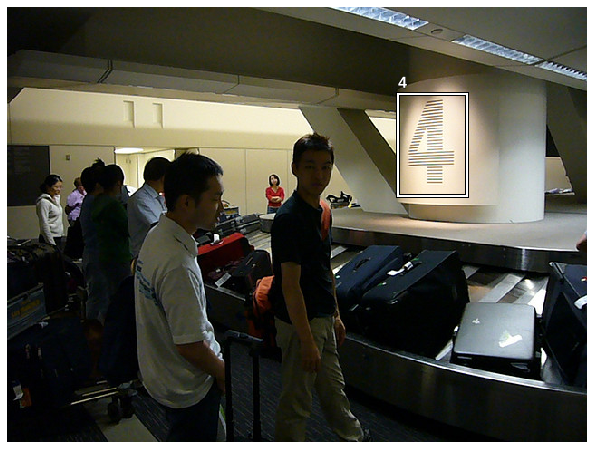

In [19]:
draw_idx(36606)

(427, 640, 3)


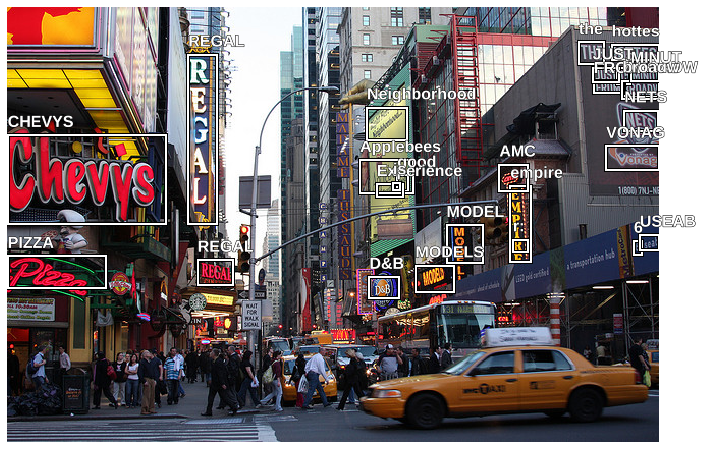

In [20]:
draw_idx(534763)

(612, 612, 3)


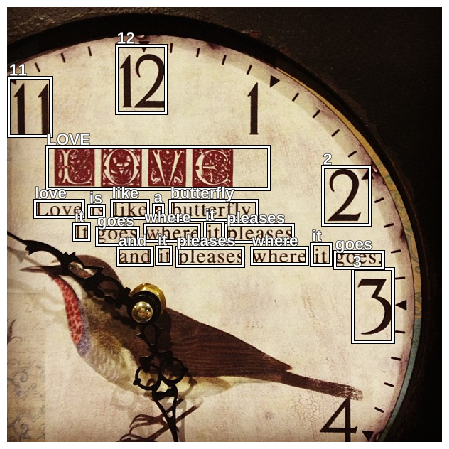

In [21]:
draw_idx(510781)

# Criando dataset e dataloader

### Criação do dataset com opção de resize, modificando o tamanho do bound box também

In [0]:
from torch.utils.data import Dataset
from torchvision import transforms

class COCODataset(Dataset):
    def __init__(self, img_path, img_ids, img_fnames, annotations, resize=None):
      
        self.img_path = img_path
        self.img_ids = img_ids
        self.img_fnames = img_fnames
        self.annotations = annotations
        self.resize = resize   
            
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, index):
        
        im = open_image(self.img_path/self.img_fnames[self.img_ids[index]])
        
        #forçando formato do torch tensor, canal na frente
        if(im.shape[2]==3):
          image = np.ones((3,im.shape[0],im.shape[1]))
          image[0,:,:] = im[:,:,0]
          image[1,:,:] = im[:,:,1]
          image[2,:,:] = im[:,:,2]
          im = image
        im = torch.tensor(im, dtype=torch.float) # imagem para tensor
        
        
        # apenas maior bb
        area = 0
        
        for i in self.annotations[self.img_ids[index]]:
          w = i[0][3] - i[0][1]
          l = i[0][2] - i[0][0]
          if(area < w*l):
            bb = i[0]
            area = w*l
            texto = i[1]
            
        bb = torch.tensor(bb, dtype=torch.float) # boundbox para tensor
        
        if self.resize:
            bb[0] = bb[0]*self.resize[0]/im.shape[1]
            bb[2] = bb[2]*self.resize[0]/im.shape[1]
            bb[1] = bb[1]*self.resize[1]/im.shape[2]
            bb[3] = bb[3]*self.resize[1]/im.shape[2]
            im = transforms.Compose([transforms.ToPILImage(),
                        transforms.Resize((self.resize[0], self.resize[1])),
                        transforms.ToTensor()])(im)

            
        return im, bb, texto

In [0]:
COCO = COCODataset(PATH_I, train_ids, train_fnames, train_anno, resize=(240,240))

In [0]:
coco_iter = iter(COCO)

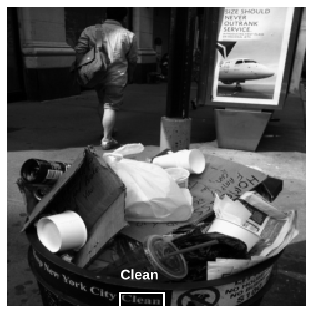

In [30]:
im, bb, text = next(coco_iter)
ax = show_img(im)
b = bb2hw(bb)
draw_rect(ax, b)
draw_text(ax, b[:2], text)

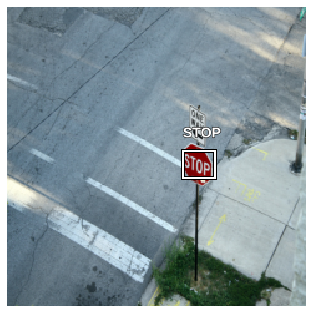

In [31]:
im, bb, text = next(coco_iter)
ax = show_img(im)
b = bb2hw(bb)
draw_rect(ax, b)
draw_text(ax, b[:2], text)

### Criação do dataloader, apenas ajustando tamanho do batch

In [0]:
from torch.utils.data import DataLoader

data_loader = DataLoader(COCO, 
                         batch_size=30, # tamanho do mini-batch de dados
                         shuffle=False) # se for True, embaralha os dados no inicio de cada iteração

In [0]:
data = next(iter(data_loader))

In [0]:
im, bb, text = data[0][20], data[1][20], data[2][20]

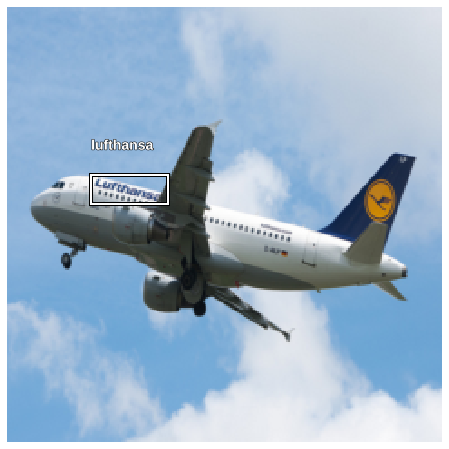

In [35]:
ax = show_img(im, figsize=(16,8))
b = bb2hw(bb)
draw_rect(ax, b)
draw_text(ax, b[:2], text)

## Criando o modelo

In [48]:
import torchvision
import torch.nn as nn
from torchvision.models.resnet import BasicBlock


class MyResNetConv(torchvision.models.ResNet):
    def __init__(self):
        super().__init__(BasicBlock, [3, 4, 6, 3]) # ResNet34
        self.load_state_dict(torch.utils.model_zoo.load_url(
            'https://download.pytorch.org/models/resnet34-333f7ec4.pth'))
        del self.fc
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        return x

class MyResNetDens(nn.Module):
    def __init__(self):
        super().__init__()
        #self.drop = nn.Dropout(0.5)
        self.dens1 = nn.Linear(in_features=2048, out_features=256)
        self.relu = nn.ReLU()
        #self.batchnorm = nn.BatchNorm1d(256)
        self.dens2 = nn.Linear(in_features=256, out_features=4)

    def forward(self, x):
        x = self.dens1(x)
        x = self.relu(x)
        #x = self.batchnorm(x)
        #x = self.drop(x)
        x = self.dens2(x)
        return x

class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mrn_conv = MyResNetConv() # instância rede convolucional
        self.mrn_dens = MyResNetDens() # instância rede densa

    def forward(self, x):
        x = self.mrn_conv(x)
        x = self.mrn_dens(x)
        return x

model = MyResNet()
use_gpu = torch.cuda.is_available()

if use_gpu:
    model = model.cuda()
print(model)

MyResNet(
  (mrn_conv): MyResNetConv(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()
  
  for epoch in range(num_epochs):
    tic = time.time()
    print('-' * 30)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print()
    scheduler.step()
    model.train()

    running_loss = 0.0

    for im, bb, text in data_loader:
      im = im.to(device)
      bb = bb.to(device)

      optimizer.zero_grad()

      outputs = model(im)
      loss = criterion(outputs,bb)

      loss.backward()
      optimizer.step()

      running_loss += loss.item() * im.size(0)

    epoch_loss = running_loss/len(COCO)
    
    print('Loss: {:.4f}'.format(epoch_loss))
    time_elapsed = time.time() - tic
    print('Time elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('-' * 30)
    print()

  time_elapsed = time.time() - since
  print('Train complete in: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

        
  return model

          


In [0]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import time, copy

num_epochs = 2
criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.mrn_dens.parameters(),lr=0.001, betas=(0.9, 0.999))
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.75)

In [58]:
model = train_model(model, 
                   criterion, 
                   optimizer,
                   exp_lr_scheduler, 
                   num_epochs = num_epochs)

------------------------------
Epoch 1/2

Loss: 3422.8892
Time elapsed: 8m 44s
------------------------------

------------------------------
Epoch 2/2

Loss: 3380.1689
Time elapsed: 8m 44s
------------------------------

Train complete in: 17m 28s


In [0]:
data = next(iter(data_loader))
im, bb, text = data

In [0]:
model.eval()
im = im[29:30].to(device)
bb_2 = model(im)

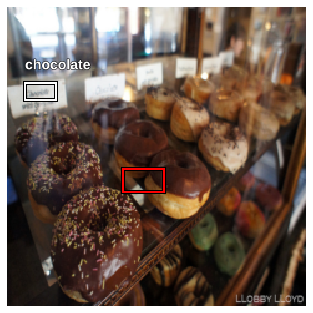

In [74]:
ax = show_img(im[0])
b = bb2hw(bb[29])
b2 = bb2hw(bb_2[0])
draw_rect(ax, b)
draw_rect_2(ax, b2)
draw_text(ax, b[:2], text[29])

In [192]:
b2

array([tensor(0.0856, device='cuda:0', grad_fn=<SelectBackward>),
       tensor(0.1142, device='cuda:0', grad_fn=<SelectBackward>),
       tensor(1.1345, device='cuda:0', grad_fn=<AddBackward>),
       tensor(1.1957, device='cuda:0', grad_fn=<AddBackward>)],
      dtype=object)

In [190]:
b

array([145.57088 ,  90.14158 ,  19.64058 ,  17.702042], dtype=float32)